### GBM Model

In [1]:
# Import the library 
import h2o 
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# display matplotlib graphics in notebook
%matplotlib inline

In [22]:
# read the dataset
train1 = pd.read_csv('train.csv')
train1.shape
#train.head(2)

(64122, 18)

In [23]:
valid1 = pd.read_csv('valid.csv')
valid1.shape
#train.head(2)

(47980, 18)

In [24]:
test1 = pd.read_csv('test.csv')
test1.head(2)

,id,chain,offer,market,repeater,offerdate,category,quantity,company,offervalue,brand,avg_category_quantity,avg_category_amount,exact_item_bought,month,week,dayOfWeek,day
0,12996040,15,unknown,9,0,1364169600000,unknown,1,unknown,0.75,unknown,0.000000,0.000000,0,3,13,Mon,25
1,13540129,14,1200581,8,0,1364601600000,1726,1,104460040,1.25,7668,1.333333,4.653333,1,3,13,Sat,30


In [20]:
# start and connect to h2o server
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from C:\Users\Yidan Wang\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\YIDANW~1\AppData\Local\Temp\tmpdwkxxx9o
  JVM stdout: C:\Users\YIDANW~1\AppData\Local\Temp\tmpdwkxxx9o\h2o_Yidan_Wang_started_from_python.out
  JVM stderr: C:\Users\YIDANW~1\AppData\Local\Temp\tmpdwkxxx9o\h2o_Yidan_Wang_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.5
H2O cluster version age:,1 month and 2 days
H2O cluster name:,H2O_from_python_Yidan_Wang_b5i747
H2O cluster total nodes:,1
H2O cluster free memory:,3.524 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [42]:
# enforce same measurement levels in h2o and pandas
col_types = {'id': 'enum',
             'chain': 'enum',
             'offer': 'enum',
             'market': 'enum',
             'category': 'enum',
             'company': 'enum',
             'brand': 'enum',
             'exact_item_bought': 'enum',
             'month':'enum',
             'week':'enum',
             'day':'enum',
             'repeater':'enum'}
trainh2o = h2o.H2OFrame(train1, column_types=col_types)
testh2o = h2o.H2OFrame(test1, column_types=col_types)
validh2o = h2o.H2OFrame(valid1, column_types=col_types)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [44]:
# check the data type
validh2o.types

{'id': 'enum',
 'chain': 'enum',
 'offer': 'enum',
 'market': 'enum',
 'repeater': 'enum',
 'offerdate': 'int',
 'category': 'enum',
 'quantity': 'int',
 'company': 'enum',
 'offervalue': 'real',
 'brand': 'enum',
 'avg_category_quantity': 'real',
 'avg_category_amount': 'real',
 'exact_item_bought': 'enum',
 'month': 'enum',
 'week': 'enum',
 'dayOfWeek': 'enum',
 'day': 'enum'}

In [83]:
trainh2o.head(1)

id,chain,offer,market,repeater,offerdate,category,quantity,company,offervalue,brand,avg_category_quantity,avg_category_amount,exact_item_bought,month,week,dayOfWeek,day
86246,205,1208251,34,1,1.36676e+12,2202,1,104460040,2,3718,0,0,0,4,17,Wed,24


In [51]:
# quantity unary, drop it
# drop other unusable variables
# set modeling roles
drops = ['id', 'chain', 'market', 'offerdate', 'quantity']
y = 'repeater'
X = [name for name in trainh2o.columns if name not in [y] + drops]
print(y)
print(X)

repeater
['offer', 'category', 'company', 'offervalue', 'brand', 'avg_category_quantity', 'avg_category_amount', 'exact_item_bought', 'month', 'week', 'dayOfWeek', 'day']


In [101]:
from h2o.targetencoder import TargetEncoder
e_columns = ['market', 'chain'] 
te_ = TargetEncoder(x=e_columns, y=y) 
_ = te_.fit(trainh2o)  
train = te_.transform(frame=trainh2o, holdout_type='loo', seed=12345) 

valid = te_.transform(frame=validh2o, holdout_type='loo', seed=12345) 
 
test = te_.transform(frame=testh2o, holdout_type='loo', seed=12345) 

In [102]:
X = [name for name in train.columns if name not in [y] + drops]

In [103]:
# GBM with random hyperparameter search
# train many different GBM models with random hyperparameters
# and select best model based on validation error

# define random grid search parameters
hyper_parameters = {'ntrees':list(range(0, 500, 50)),
                    'max_depth':list(range(0, 20, 2)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':60,
                   'max_runtime_secs':3600}

# initialize grid search
gsearch = H2OGridSearch(H2OGradientBoostingEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid)


gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: col_sample_rate, 0.6
Hyper-parameter: max_depth, 0
Hyper-parameter: ntrees, 150
Hyper-parameter: sample_rate, 0.4
failure_details: Illegal argument(s) for GBM model: Grid_GBM_py_42_sid_be81_model_python_1554686701936_11847_model_3.  Details: ERRR on field: _max_depth: _max_depth must be > 0.

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: Grid_GBM_py_42_sid_be81_model_python_1554686701936_11847_model_3.  Details: ERRR on field: _max_depth: _max_depth must be > 0.

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.gbm.GBM.init(GBM.java:84)
	at hex.tree.SharedTree$Driver.computeImpl(SharedTree.java:207)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:218)
	at hex.ModelBuilder.trainModelNe

In [104]:
# show grid search results
gsearch.show()

# select best model
gbm_model = gsearch.get_grid()[0]

# print model information
gbm_model

     col_sample_rate max_depth ntrees sample_rate  \
0                0.7         2    450         1.0   
1                0.8         4    300         0.6   
2                0.2         4    450         0.6   
3                0.7         2    400         0.8   
4                0.2         4    200         1.0   
5                0.3         4    100         1.0   
6                0.8         6    300         0.8   
7                0.8         8    450         1.0   
8                0.7         8    300         1.0   
9                0.6         8    100         1.0   
10               0.6         2    350         0.7   
11               0.2         6    150         0.5   
12               0.3         6     50         0.4   
13               0.1        16     50         0.6   
14               0.1        10    400         0.7   
15               0.2         4     50         0.8   
16               0.1         2    400         0.2   
17               0.8         6     50         

55  0.6612904517523819  
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_py_42_sid_be81_model_python_1554686701936_11847_model_20


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1752068363782272
RMSE: 0.4185771570191417
LogLoss: 0.526535296277656
Mean Per-Class Error: 0.34616249376777
AUC: 0.7103282647715191
pr_auc: 0.4702978541542291
Gini: 0.4206565295430382
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2612896031282605: 


,0,1,Error,Rate
0,28248.0,18601.0,0.397,(18601.0/46849.0)
1,5117.0,12156.0,0.2962,(5117.0/17273.0)
Total,33365.0,30757.0,0.3699,(23718.0/64122.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2612896,0.5061836,230.0
max f2,0.1392853,0.6699249,328.0
max f0point5,0.3962759,0.4673039,133.0
max accuracy,0.4641061,0.7433642,90.0
max precision,0.8746279,1.0,0.0
max recall,0.0282116,1.0,396.0
max specificity,0.8746279,1.0,0.0
max absolute_mcc,0.3018306,0.2773992,203.0
max min_per_class_accuracy,0.2918324,0.6530423,210.0
max mean_per_class_accuracy,0.2902088,0.6538375,211.0


Gains/Lift Table: Avg response rate: 26.94 %, avg score: 26.94 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100122,0.5994768,2.7870919,2.7870919,0.7507788,0.6336634,0.7507788,0.6336634,0.0279048,0.0279048,178.7091950,178.7091950
,2,0.0200087,0.5683449,2.2528426,2.5201755,0.6068643,0.5820386,0.6788776,0.6078711,0.0225207,0.0504255,125.2842645,152.0175501
,3,0.0300053,0.5471770,2.1775548,2.4060280,0.5865835,0.5577548,0.6481289,0.5911744,0.0217681,0.0721936,117.7554845,140.6027975
,4,0.0400175,0.5348652,1.9833455,2.3002750,0.5342679,0.5400675,0.6196415,0.5783877,0.0198576,0.0920512,98.3345516,130.0274998
,5,0.0500140,0.5215953,2.0964757,2.2595406,0.5647426,0.5280329,0.6086685,0.5683230,0.0209576,0.1130087,109.6475675,125.9540553
,6,0.1000125,0.4663321,1.9128716,2.0862331,0.5152838,0.4927555,0.5619835,0.5305451,0.0956406,0.2086493,91.2871566,108.6233088
,7,0.1500109,0.4282600,1.7310793,1.9678608,0.4663132,0.4475700,0.5300967,0.5028896,0.0865513,0.2952006,73.1079293,96.7860797
,8,0.2000094,0.3882045,1.5064443,1.8525157,0.4058016,0.4085970,0.4990253,0.4793183,0.0753199,0.3705205,50.6444254,85.2515656
,9,0.3000374,0.3375914,1.3288691,1.6779396,0.3579669,0.3591462,0.4519985,0.4392547,0.1329242,0.5034447,32.8869137,67.7939598
,10,0.4000343,0.3040495,1.1995974,1.5583680,0.3231441,0.3217034,0.4197887,0.4098703,0.1199560,0.6234007,19.9597423,55.8368040




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.17914556532231216
RMSE: 0.4232559099673768
LogLoss: 0.536873264929485
Mean Per-Class Error: 0.3578485708911794
AUC: 0.6918774629316737
pr_auc: 0.4467014124541208
Gini: 0.3837549258633475
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25192970549772076: 


,0,1,Error,Rate
0,20327.0,14666.0,0.4191,(14666.0/34993.0)
1,3865.0,9122.0,0.2976,(3865.0/12987.0)
Total,24192.0,23788.0,0.3862,(18531.0/47980.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2519297,0.4960979,235.0
max f2,0.1329745,0.6662392,334.0
max f0point5,0.3845732,0.4542605,142.0
max accuracy,0.5047479,0.7383493,69.0
max precision,0.7879750,1.0,0.0
max recall,0.0245855,1.0,398.0
max specificity,0.7879750,1.0,0.0
max absolute_mcc,0.2785754,0.2536870,218.0
max min_per_class_accuracy,0.2884121,0.6399476,212.0
max mean_per_class_accuracy,0.2785754,0.6421514,218.0


Gains/Lift Table: Avg response rate: 27.07 %, avg score: 27.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100042,0.5942892,2.4014014,2.4014014,0.65,0.6279272,0.65,0.6279272,0.0240240,0.0240240,140.1401401,140.1401401
,2,0.0200292,0.5664419,2.1429426,2.2720375,0.5800416,0.5781618,0.6149844,0.6030186,0.0214830,0.0455070,114.2942559,127.2037506
,3,0.0300125,0.5458922,2.0207714,2.1884566,0.5469729,0.5547119,0.5923611,0.5869499,0.0201740,0.0656811,102.0771374,118.8456619
,4,0.0400167,0.5329599,2.1628006,2.1820426,0.5854167,0.5388259,0.590625,0.5749189,0.0216370,0.0873181,116.2800621,118.2042620
,5,0.05,0.5198091,1.9744942,2.1406021,0.5344468,0.5263813,0.5794081,0.5652276,0.0197120,0.1070301,97.4494167,114.0602141
,6,0.1000625,0.4660209,1.8703030,2.0053681,0.5062448,0.4917412,0.5428036,0.5284614,0.0936321,0.2006622,87.0303019,100.5368129
,7,0.15,0.4290606,1.6498648,1.8870152,0.4465776,0.4481689,0.5107684,0.5017307,0.0823901,0.2830523,64.9864839,88.7015220
,8,0.2,0.3885898,1.5215215,1.7956418,0.4118383,0.4094890,0.4860358,0.4786703,0.0760761,0.3591284,52.1521522,79.5641796
,9,0.3000417,0.3378423,1.2330273,1.6080515,0.33375,0.3596220,0.4352598,0.4389765,0.1233541,0.4824825,23.3027258,60.8051508
,10,0.4000208,0.3044152,1.2014516,1.5064280,0.3252033,0.3220639,0.4077528,0.4097560,0.1201201,0.6026026,20.1451608,50.6428014



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-04-07 22:44:16,3 min 19.381 sec,0.0,0.4436362,0.5826383,0.5,0.0,1.0,0.7306229,0.4443105,0.5839336,0.5,0.0,1.0,0.7293247
,2019-04-07 22:44:16,3 min 19.426 sec,1.0,0.4409821,0.5766849,0.6492024,0.2500205,1.5520199,0.3844390,0.4418712,0.5784530,0.6367749,0.2457152,1.4900242,0.3936849
,2019-04-07 22:44:16,3 min 19.469 sec,2.0,0.4392618,0.5728477,0.6591633,0.3767382,1.9058637,0.3755497,0.4401799,0.5746710,0.6517744,0.3711347,1.7015847,0.3837849
,2019-04-07 22:44:16,3 min 19.510 sec,3.0,0.4377186,0.5693661,0.6609823,0.3765756,1.9059358,0.3760020,0.4387246,0.5713792,0.6534275,0.3711335,1.7032224,0.3842851
,2019-04-07 22:44:16,3 min 19.551 sec,4.0,0.4364820,0.5666529,0.6693972,0.4015833,1.7729154,0.3750039,0.4376076,0.5689293,0.6615508,0.3937874,1.7425998,0.3830971
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2019-04-07 22:44:19,3 min 23.087 sec,49.0,0.4232642,0.5370269,0.6936800,0.4381756,2.3451589,0.3966657,0.4259587,0.5429524,0.6823884,0.4275750,2.2552549,0.4077741
,2019-04-07 22:44:19,3 min 23.206 sec,50.0,0.4232110,0.5369192,0.6937512,0.4385564,2.3420042,0.3854527,0.4259114,0.5428592,0.6824352,0.4277975,2.2301945,0.4129429
,2019-04-07 22:44:20,3 min 23.327 sec,51.0,0.4231502,0.5367536,0.6939241,0.4386315,2.3420042,0.3804934,0.4258680,0.5427395,0.6825987,0.4278834,2.2301945,0.4133806
,2019-04-07 22:44:24,3 min 27.331 sec,280.0,0.4195620,0.5286984,0.7066921,0.4639591,2.7341509,0.3645395,0.4237154,0.5378586,0.6903129,0.4428140,2.3128564,0.3945394



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
chain_te,1930.0433350,1.0,0.2671586
week,1222.6666260,0.6334918,0.1692428
offervalue,762.3202515,0.3949757,0.1055212
offer,654.7229614,0.3392271,0.0906274
avg_category_amount,643.2063599,0.3332601,0.0890333
category,591.4963989,0.3064679,0.0818755
avg_category_quantity,361.0173035,0.1870514,0.0499724
brand,356.0525208,0.1844790,0.0492852
day,293.1764832,0.1519015,0.0405818
market_te,262.8861694,0.1362074,0.0363890


In [105]:
# measure gbm AUC
print(gbm_model.auc(train=True))
print(gbm_model.auc(valid=True))
print(gbm_model.model_performance(test_data=test).auc())

0.7103282647715191
0.6918774629316737
0.7000350035005901


### MLP

In [111]:
#select top 10 important variables from GBM model
top10 = gbm_model._model_json['output']['variable_importances'].as_data_frame().head(10)
names10=top10['variable'].values.tolist()
names10

['chain_te',
 'week',
 'offervalue',
 'offer',
 'avg_category_amount',
 'category',
 'avg_category_quantity',
 'brand',
 'day',
 'market_te']

In [112]:
X = names10

In [113]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
# neural network

# initialize nn model
nn_model = H2ODeepLearningEstimator(
    epochs=50,                    # read over the data 50 times, but in mini-batches
    hidden=[100],                 # 100 hidden units in 1 hidden layer
    input_dropout_ratio=0.2,      # randomly drop 20% of inputs for each iteration, helps w/ generalization
    hidden_dropout_ratios=[0.05], # randomly set 5% of hidden weights to 0 each iteration, helps w/ generalization
    activation='TanhWithDropout', # bounded activation function that allows for dropout, tanh
    l1=0.001,                     # L1 penalty can help generalization   
    l2=0.01,                      # L2 penalty can increase stability in presence of highly correlated inputs
    adaptive_rate=True,           # adjust magnitude of weight updates automatically (+stability, +accuracy)
    stopping_rounds=5,            # stop after validation error does not decrease for 5 iterations
    score_each_iteration=True,    # score validation error on every iteration
    model_id='nn_model')          # for easy lookup in flow

# train nn model
nn_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid)

# print model information
nn_model

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  nn_model


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18151774919605906
RMSE: 0.4260489985859127
LogLoss: 0.5436913893231691
Mean Per-Class Error: 0.3577259838422049
AUC: 0.6834398685869731
pr_auc: 0.4264978074704821
Gini: 0.3668797371739463
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.285845303258119: 


,0,1,Error,Rate
0,4567.0,2782.0,0.3786,(2782.0/7349.0)
1,917.0,1794.0,0.3383,(917.0/2711.0)
Total,5484.0,4576.0,0.3677,(3699.0/10060.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2858453,0.4923837,210.0
max f2,0.1783814,0.6572498,326.0
max f0point5,0.3479915,0.4462872,149.0
max accuracy,0.4420093,0.7350895,59.0
max precision,0.5784217,0.8,2.0
max recall,0.1102146,1.0,396.0
max specificity,0.6124611,0.9998639,0.0
max absolute_mcc,0.3191271,0.2553122,180.0
max min_per_class_accuracy,0.2954759,0.6418296,201.0
max mean_per_class_accuracy,0.2979134,0.6422740,199.0


Gains/Lift Table: Avg response rate: 26.95 %, avg score: 28.01 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100398,0.4925625,2.3514030,2.3514030,0.6336634,0.5194312,0.6336634,0.5194312,0.0236075,0.0236075,135.1402975,135.1402975
,2,0.0200795,0.4788421,1.8737742,2.1125886,0.5049505,0.4849396,0.5693069,0.5021854,0.0188122,0.0424198,87.3774246,111.2588610
,3,0.0300199,0.4689855,1.9667281,2.0642904,0.53,0.4734252,0.5562914,0.4926622,0.0195500,0.0619698,96.6728145,106.4290443
,4,0.0400596,0.4625597,1.9472556,2.0349591,0.5247525,0.4655817,0.5483871,0.4858753,0.0195500,0.0815197,94.7255589,103.4959127
,5,0.05,0.4550029,1.8925120,2.0066396,0.51,0.4587926,0.5407555,0.4804910,0.0188122,0.1003320,89.2511988,100.6639616
,6,0.1,0.4277419,1.6967909,1.8517152,0.4572565,0.4401061,0.4990060,0.4602986,0.0848395,0.1851715,69.6790852,85.1715234
,7,0.15,0.4061542,1.5713759,1.7582688,0.4234592,0.4169487,0.4738237,0.4458486,0.0785688,0.2637403,57.1375876,75.8268782
,8,0.2,0.3745349,1.5566212,1.7078569,0.4194831,0.3901503,0.4602386,0.4319240,0.0778311,0.3415714,55.6621173,70.7856879
,9,0.3,0.3462780,1.4127628,1.6094922,0.3807157,0.3588926,0.4337309,0.4075802,0.1412763,0.4828477,41.2762818,60.9492192
,10,0.4,0.3110739,1.2283290,1.5142014,0.3310139,0.3300295,0.4080517,0.3881925,0.1228329,0.6056806,22.8329030,51.4201402




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18447030301299627
RMSE: 0.42950006171477584
LogLoss: 0.550731622132268
Mean Per-Class Error: 0.3740280203572862
AUC: 0.6662010992877166
pr_auc: 0.4069817439654198
Gini: 0.3324021985754333
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2541835519647539: 


,0,1,Error,Rate
0,18430.0,16563.0,0.4733,(16563.0/34993.0)
1,3679.0,9308.0,0.2833,(3679.0/12987.0)
Total,22109.0,25871.0,0.4219,(20242.0/47980.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2541836,0.4790777,246.0
max f2,0.1504331,0.6581282,356.0
max f0point5,0.3244520,0.4229025,176.0
max accuracy,0.4666523,0.7315548,44.0
max precision,0.5794413,0.7647059,4.0
max recall,0.1036018,1.0,399.0
max specificity,0.6421695,0.9999143,0.0
max absolute_mcc,0.3119525,0.2261352,188.0
max min_per_class_accuracy,0.2931138,0.6243166,207.0
max mean_per_class_accuracy,0.2794312,0.6259720,220.0


Gains/Lift Table: Avg response rate: 27.07 %, avg score: 28.01 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100042,0.4906893,1.9703806,1.9703806,0.5333333,0.5142714,0.5333333,0.5142714,0.0197120,0.0197120,97.0380637,97.0380637
,2,0.0200083,0.4767375,1.9626838,1.9665322,0.53125,0.4832435,0.5322917,0.4987574,0.0196350,0.0393470,96.2683838,96.6532237
,3,0.0300125,0.4671415,2.0088646,1.9806430,0.54375,0.4718121,0.5361111,0.4897757,0.0200970,0.0594441,100.8864634,98.0643036
,4,0.0400167,0.4594288,1.7933543,1.9338208,0.4854167,0.4632316,0.5234375,0.4831396,0.0179410,0.0773851,79.3354252,93.3820840
,5,0.05,0.4522467,1.6891181,1.8849619,0.4572025,0.4558347,0.5102126,0.4776878,0.0168630,0.0942481,68.9118057,88.4961885
,6,0.1,0.4272068,1.6447216,1.7648418,0.4451855,0.4386562,0.4776990,0.4581720,0.0822361,0.1764842,64.4721645,76.4841765
,7,0.15,0.4045720,1.4784015,1.6693617,0.4001667,0.4165312,0.4518549,0.4442917,0.0739201,0.2504043,47.8401478,66.9361669
,8,0.2,0.3720901,1.5184415,1.6316316,0.4110046,0.3874746,0.4416424,0.4300874,0.0759221,0.3263263,51.8441518,63.1631632
,9,0.3,0.3452111,1.3105413,1.5246015,0.3547311,0.3577766,0.4126719,0.4059838,0.1310541,0.4573805,31.0541311,52.4601525
,10,0.4,0.3129458,1.2397012,1.4533765,0.3355565,0.3302978,0.3933931,0.3870623,0.1239701,0.5813506,23.9701240,45.3376453



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-04-07 22:58:22,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2019-04-07 22:58:23,2.018 sec,66040 obs/sec,1.5592932,1,99985.0,0.4280887,0.5473515,0.0690941,0.6716368,0.4141827,2.2044403,0.4206759,0.4317242,0.5549056,0.0558451,0.6542994,0.3927329,2.1474070,0.4449562
,2019-04-07 22:58:25,3.799 sec,67597 obs/sec,3.1193662,2,200020.0,0.4305973,0.5526293,0.0581520,0.6728714,0.4131047,2.3146623,0.3999006,0.4344552,0.5611180,0.0438622,0.6562160,0.3907679,2.0242582,0.4162151
,2019-04-07 22:58:27,5.581 sec,67283 obs/sec,4.6777861,3,299949.0,0.4316270,0.5553625,0.0536422,0.6728991,0.4132398,2.2779216,0.3879722,0.4353218,0.5637135,0.0400443,0.6572573,0.3938478,2.0935294,0.4081075
,2019-04-07 22:58:29,7.623 sec,65091 obs/sec,6.2409781,4,400184.0,0.4304712,0.5526330,0.0587036,0.6669447,0.4092591,2.3514030,0.4027833,0.4338136,0.5598035,0.0466842,0.6518080,0.3905022,2.0858326,0.4105252
,2019-04-07 22:58:30,9.247 sec,66650 obs/sec,7.7988522,5,500078.0,0.4282270,0.5473907,0.0684926,0.6796419,0.4217700,2.3514030,0.3901590,0.4319395,0.5555403,0.0549033,0.6629084,0.3993210,2.0704390,0.3930388
,2019-04-07 22:58:33,11.470 sec,64322 obs/sec,9.3592371,6,600133.0,0.4317700,0.5552303,0.0530151,0.6667409,0.4089949,2.2411810,0.4258449,0.4351019,0.5626465,0.0410137,0.6506846,0.3898723,2.1243166,0.4139433
,2019-04-07 22:58:35,13.802 sec,62433 obs/sec,10.9187018,7,700129.0,0.4302238,0.5521933,0.0597855,0.6644257,0.4086336,2.2044403,0.4145129,0.4336261,0.5593044,0.0475079,0.6502489,0.3897961,2.0550454,0.4316382
,2019-04-07 22:58:37,16.176 sec,60372 obs/sec,12.4752347,8,799937.0,0.4281082,0.5472096,0.0690095,0.6795528,0.4189731,2.3514030,0.3938370,0.4318633,0.5553457,0.0552366,0.6631999,0.3977530,2.0165614,0.4229679
,2019-04-07 22:58:40,18.704 sec,58855 obs/sec,14.0360251,9,900018.0,0.4287560,0.5478610,0.0661897,0.6760672,0.4163662,2.2779216,0.3815109,0.4333374,0.5572329,0.0487758,0.6595711,0.3964095,2.0319550,0.4059191


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
brand.7668,1.0,1.0,0.0718389
week.9,0.6444629,0.6444629,0.0462975
week.12,0.6079693,0.6079693,0.0436759
day.14,0.5236077,0.5236077,0.0376154
week.11,0.5156447,0.5156447,0.0370434
---,---,---,---
day.missing(NA),0.0,0.0,0.0
offer.missing(NA),0.0,0.0,0.0
week.missing(NA),0.0,0.0,0.0
category.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [114]:
# measure nn AUC
print(nn_model.auc(train=True))
print(nn_model.auc(valid=True))
print(nn_model.model_performance(test_data=test).auc())

0.6834398685869731
0.6662010992877166
0.6745835038816992


In [115]:
# NN with random hyperparameter search
# train many different NN models with random hyperparameters
# and select best model based on validation error

# define random grid search parameters
hyper_parameters = {'hidden':[[170, 320], [80, 190], [320, 160, 80], [100], [50, 50, 50, 50]],
                    'l1':[s/1e4 for s in range(0, 1000, 100)],
                    'l2':[s/1e5 for s in range(0, 1000, 100)],
                    'input_dropout_ratio':[s/1e2 for s in range(0, 20, 2)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':60,
                   'max_runtime_secs':2400
                   }
# initialize grid search
gsearch = H2OGridSearch(H2ODeepLearningEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)


# execute training w/ grid search
gsearch.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid)


deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [116]:
# show grid search results
gsearch.show()

# select best model
nn_model1 = gsearch.get_grid()[0]

# print model information
nn_model1

                hidden input_dropout_ratio    l1     l2  \
0            [80, 190]                 0.0   0.0  0.001   
1            [80, 190]                0.14   0.0  0.001   
2            [80, 190]                0.02   0.0  0.005   
3       [320, 160, 80]                0.08   0.0  0.009   
4                [100]                 0.0  0.01  0.004   
5                [100]                 0.1  0.01  0.007   
6            [80, 190]                0.08  0.01  0.002   
7                [100]                 0.1  0.01  0.003   
8                [100]                0.06  0.02  0.005   
9                [100]                0.02  0.02  0.007   
10               [100]                0.14  0.03  0.008   
11               [100]                0.12  0.02  0.003   
12               [100]                0.18  0.04  0.007   
13               [100]                 0.0  0.04  0.002   
14               [100]                0.14  0.08  0.001   
15               [100]                0.12  0.07  0.007 

59  0.7537832750142842  
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  Grid_DeepLearning_py_42_sid_be81_model_python_1554686701936_16072_model_13


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17935788570261443
RMSE: 0.4235066536698266
LogLoss: 0.5378354826032855
Mean Per-Class Error: 0.3505291767292975
AUC: 0.694863275076285
pr_auc: 0.4535438314030635
Gini: 0.38972655015256996
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25526284060500865: 


,0,1,Error,Rate
0,4233.0,3098.0,0.4226,(3098.0/7331.0)
1,773.0,1969.0,0.2819,(773.0/2742.0)
Total,5006.0,5067.0,0.3843,(3871.0/10073.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2552628,0.5042899,224.0
max f2,0.0957013,0.6688093,346.0
max f0point5,0.4157564,0.4512221,108.0
max accuracy,0.5072394,0.7380125,53.0
max precision,0.6867531,1.0,0.0
max recall,0.0055363,1.0,399.0
max specificity,0.6867531,1.0,0.0
max absolute_mcc,0.2817927,0.2669711,206.0
max min_per_class_accuracy,0.2962688,0.6455142,196.0
max mean_per_class_accuracy,0.2817927,0.6494708,206.0


Gains/Lift Table: Avg response rate: 27.22 %, avg score: 26.70 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100268,0.5698975,2.6188010,2.6188010,0.7128713,0.6011715,0.7128713,0.6011715,0.0262582,0.0262582,161.8801049,161.8801049
,2,0.0200536,0.5553588,2.0368453,2.3278232,0.5544554,0.5617565,0.6336634,0.5814640,0.0204230,0.0466813,103.6845260,132.7823154
,3,0.0300804,0.5433239,2.1095897,2.2550787,0.5742574,0.5485136,0.6138614,0.5704805,0.0211524,0.0678337,110.9589734,125.5078681
,4,0.0400079,0.5286876,1.9470058,2.1786338,0.53,0.5359695,0.5930521,0.5619170,0.0193290,0.0871627,94.7005835,117.8633806
,5,0.0500347,0.5179046,2.0732175,2.1575087,0.5643564,0.5228189,0.5873016,0.5540819,0.0207877,0.1079504,107.3217497,115.7508712
,6,0.1000695,0.4684414,1.8440868,2.0007978,0.5019841,0.4934044,0.5446429,0.5237431,0.0922684,0.2002188,84.4086838,100.0797775
,7,0.1500050,0.4307900,1.6870788,1.8963632,0.4592445,0.4494463,0.5162144,0.4990103,0.0842451,0.2844639,68.7078840,89.6363212
,8,0.2000397,0.3890209,1.3338652,1.7556689,0.3630952,0.4104223,0.4779156,0.4768523,0.0667396,0.3512035,33.3865184,75.5668916
,9,0.3000099,0.3435600,1.3278937,1.6131243,0.3614697,0.3640648,0.4391132,0.4392689,0.1327498,0.4839533,32.7893658,61.3124348
,10,0.3999801,0.3113970,1.2512844,1.5226868,0.3406157,0.3296266,0.4144949,0.4118651,0.1250912,0.6090445,25.1284408,52.2686815




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18078682980010913
RMSE: 0.4251903453749969
LogLoss: 0.5422883521552159
Mean Per-Class Error: 0.36137054050636763
AUC: 0.6855168270451327
pr_auc: 0.4356305768756353
Gini: 0.37103365409026545
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2570203208641622: 


,0,1,Error,Rate
0,19933.0,15060.0,0.4304,(15060.0/34993.0)
1,3797.0,9190.0,0.2924,(3797.0/12987.0)
Total,23730.0,24250.0,0.393,(18857.0/47980.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2570203,0.4935951,226.0
max f2,0.0976684,0.6630616,346.0
max f0point5,0.3774046,0.4463530,136.0
max accuracy,0.5084776,0.7368695,57.0
max precision,0.7042081,1.0,0.0
max recall,0.0071411,1.0,399.0
max specificity,0.7042081,1.0,0.0
max absolute_mcc,0.2570203,0.2463915,226.0
max min_per_class_accuracy,0.2956108,0.6334796,200.0
max mean_per_class_accuracy,0.2570203,0.6386295,226.0


Gains/Lift Table: Avg response rate: 27.07 %, avg score: 26.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100042,0.5713195,2.2089814,2.2089814,0.5979167,0.6014842,0.5979167,0.6014842,0.0220990,0.0220990,120.8981417,120.8981417
,2,0.0200083,0.5552600,2.2012846,2.2051330,0.5958333,0.5618921,0.596875,0.5816881,0.0220220,0.0441210,120.1284618,120.5133018
,3,0.0300125,0.5448928,2.1781942,2.1961534,0.5895833,0.5498227,0.5944444,0.5710663,0.0217910,0.0659121,117.8194220,119.6153418
,4,0.0400167,0.5333362,1.9857742,2.1435586,0.5375,0.5392094,0.5802083,0.5631021,0.0198660,0.0857781,98.5774236,114.3558623
,5,0.05,0.5217963,1.8665140,2.0882421,0.5052192,0.5274915,0.5652355,0.5559918,0.0186340,0.1044121,86.6514017,108.8242088
,6,0.1,0.4714340,1.8264418,1.9573420,0.4943727,0.4963629,0.5298041,0.5261774,0.0913221,0.1957342,82.6441826,95.7341957
,7,0.15,0.4357151,1.6385616,1.8510819,0.4435181,0.4538540,0.5010421,0.5020696,0.0819281,0.2776623,63.8561639,85.1081851
,8,0.2,0.3938289,1.4707015,1.7559868,0.3980825,0.4149513,0.4753022,0.4802900,0.0735351,0.3511974,47.0701471,75.5986756
,9,0.3,0.3450100,1.2728113,1.5949283,0.3445185,0.3662116,0.4317077,0.4422639,0.1272811,0.4784785,27.2811273,59.4928262
,10,0.4,0.3142699,1.1165011,1.4753215,0.3022093,0.3318471,0.3993331,0.4146597,0.1116501,0.5901286,11.6501117,47.5321475



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-04-07 23:02:12,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2019-04-07 23:02:14,1 min 35.527 sec,24776 obs/sec,1.0,1,64122.0,0.4377045,0.5728715,0.0329497,0.6831544,0.4297295,2.3278232,0.4234091,0.4371506,0.5726682,0.0319616,0.6769000,0.4226585,2.2628590,0.4051063
,2019-04-07 23:02:21,1 min 42.244 sec,59200 obs/sec,8.0,8,512976.0,0.4235067,0.5378355,0.0946688,0.6948633,0.4535438,2.6188010,0.3842946,0.4251903,0.5422884,0.0842071,0.6855168,0.4356306,2.2089814,0.3930179
,2019-04-07 23:02:23,1 min 44.511 sec,62320 obs/sec,10.0,10,641220.0,0.4235727,0.5383319,0.0943866,0.6959491,0.4521874,2.5824288,0.3704954,0.4255095,0.5435218,0.0828317,0.6847988,0.4334746,2.2166782,0.3931430
,2019-04-07 23:02:24,1 min 45.310 sec,62193 obs/sec,10.0,10,641220.0,0.4235067,0.5378355,0.0946688,0.6948633,0.4535438,2.6188010,0.3842946,0.4251903,0.5422884,0.0842071,0.6855168,0.4356306,2.2089814,0.3930179


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
category.unknown,1.0,1.0,0.0151537
offer.1208503,0.9785212,0.9785212,0.0148282
day.19,0.9664797,0.9664797,0.0146458
brand.7668,0.9498348,0.9498348,0.0143935
offer.1208252,0.9357052,0.9357052,0.0141794
---,---,---,---
day.missing(NA),0.0,0.0,0.0
offer.missing(NA),0.0,0.0,0.0
week.missing(NA),0.0,0.0,0.0
category.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [118]:
# measure nn AUC
print(nn_model1.auc(train=True))
print(nn_model1.auc(valid=True))
print(nn_model1.model_performance(test_data=test).auc())

0.694863275076285
0.6855168270451327
0.692472239479926


#### 1. What is the value for chain_te for row id 258692579? 

In [119]:
test[test['id']=='258692579',['id','chain_te']]


id,chain_te
258692579,0.131497


#### 2. What is the value of market_te for the same row? 

In [120]:
test[test['id']=='258692579',['id','market_te']]

id,market_te
258692579,0.121452


#### 3. What is the test AUC of your best GBM model?

In [121]:
print(gbm_model.model_performance(test_data=test).auc())

0.7000350035005901


#### 4. What are the three most important variables for your best GBM? Paste a screenshot of your output here. 

In [122]:

gbm_model._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,chain_te,1930.043335,1.000000,0.267159
1,week,1222.666626,0.633492,0.169243
2,offervalue,762.320251,0.394976,0.105521
3,offer,654.722961,0.339227,0.090627
4,avg_category_amount,643.206360,0.333260,0.089033
5,category,591.496399,0.306468,0.081876
6,avg_category_quantity,361.017303,0.187051,0.049972
7,brand,356.052521,0.184479,0.049285
8,day,293.176483,0.151902,0.040582
9,market_te,262.886169,0.136207,0.036389


#### 5. Paste the partial dependence plot of the most important variable in the GBM model’s test data here. 

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


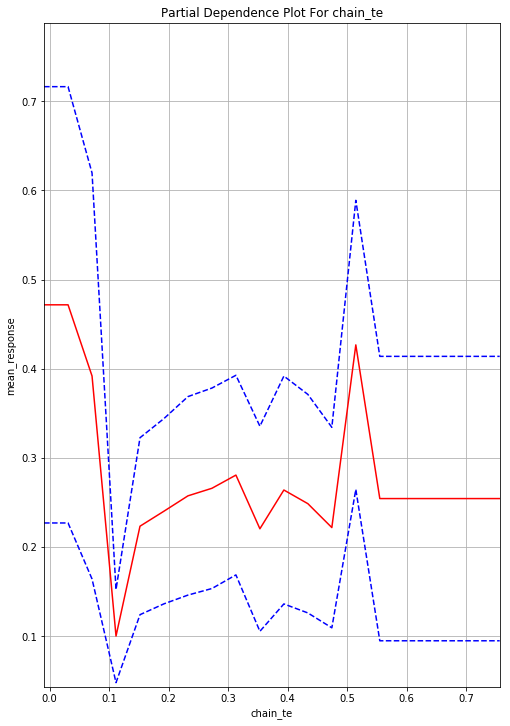

In [123]:
par_dep_chain_te = gbm_model.partial_plot(data=test, cols=['chain_te'], server=True, plot=True)

#### 6. (1 pt.) What is the test AUC of your best MLP model? Paste a screenshot of your output here. 

In [124]:
print(nn_model.model_performance(test_data=test).auc())

0.6745835038816992


#### 7. (1 pt.) Paste the partial dependence plot of the same variable in #5, but for your best ANN model’s test data, here. 

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


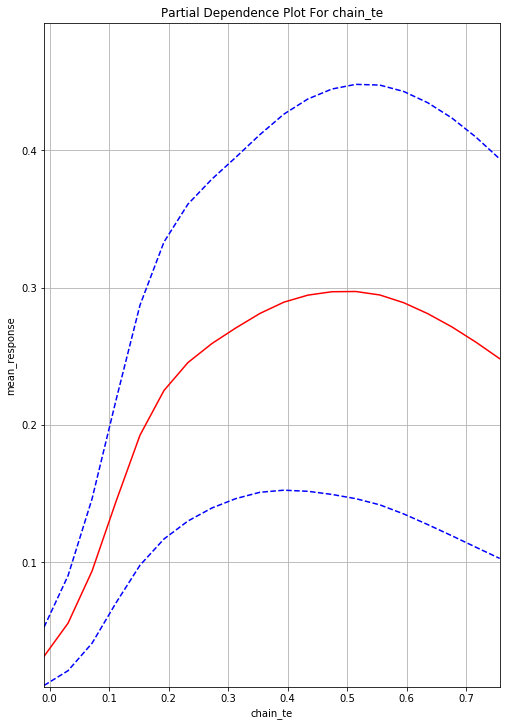

In [125]:
par_dep_chain_te1 = nn_model1.partial_plot(data=test, cols=['chain_te'], server=True, plot=True)